In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Ryan Jewik\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Ryan Jewik\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('../final/o-kids-math-games.csv')

In [3]:
df = pd.read_excel("../Deductive_Analysis_Mar3.xlsx", sheet_name="o-khan-academy-kids")
df.rename(columns={'Sentence': 'review'}, inplace=True)
df.rename(columns={'Code': 'Name'}, inplace=True)

In [4]:
df['Name'].value_counts()

Name
Goal oriented                        300
Education                            130
Engaging/Fun                         115
Quality Screen Time                   93
Ease of Use                           78
Well Rounded                          54
Personalization/Variety               42
Targeted                              40
Open-Ended/Explore                    23
Independence                          23
Reinforcement                         17
Attention/Focus                       17
Structure                             15
Creative                              15
Boring                                15
Self Mastery/Growth                   14
Cost                                  13
Auditory Stimuli                      12
Travel                                12
Adult assistance                       7
Calming/Stimulating                    6
Over Stimulated                        6
Fine Motor Skills                      4
Visual Stimuli                         3
Wifi       

In [5]:
from transformers import pipeline
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

emotions dataframe by passing dataframe into roberta model

In [6]:
#create the emotions dataframe needed for spider graphs
def analyze_app_emotions(reviews, app_name):
    emotions_df = pd.DataFrame()
    skipped_count = 0
    
    for review in reviews:
        try:
            # Get emotions for current review
            emotions = classifier(review)
            
            # Create dictionary mapping labels to scores
            row_data = {'review': review, 'Name': app_name}
            for emotion in emotions[0]:
                row_data[emotion['label']] = emotion['score']
                
            # Convert to DataFrame row and concatenate
            review_df = pd.DataFrame([row_data])
            emotions_df = pd.concat([emotions_df, review_df], ignore_index=True)
            
        except RuntimeError as e:
            skipped_count += 1
            continue
    
    return emotions_df

create 1 spider

In [7]:
#create 1 spider
def create_emotion_spider(emotions_df, title_suffix, color, figsize):
    # Create buffer to store image
    from io import BytesIO
    import base64
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Calculate means and get top 6
    emotion_means = emotions_df.drop(['review', 'Name'], axis=1).mean()
    top_emotions = dict(sorted(emotion_means.items(), key=lambda x: x[1], reverse=True)[:6])
    
    # Prepare data
    emotions = [emotion.capitalize() for emotion in top_emotions.keys()]
    values = list(top_emotions.values())
    
    # Setup angles
    num_vars = len(emotions)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]
    values += values[:1]
    
    # Plot data
    ax.plot(angles, values, 'o-', linewidth=2, color=color, label='Top 6 Emotions')
    ax.fill(angles, values, alpha=0.25, color=color)
    
    # Customize chart
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(emotions, size=10)
    ax.set_rgrids([0.1, 0.2, 0.3, 0.4, 0.5])
    
    plt.title(f"Emotional Analysis: {title_suffix}", size=15, y=1.05)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    
    # Save plot to buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image_png = buffer.getvalue()
    graph = base64.b64encode(image_png).decode('utf-8')
    buffer.close()
    plt.show()
    # Clear the current figure
    plt.close()
    
    # Encode
    
    
    return graph

combining multiple spiders

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64

def create_combined_emotion_spider(df1, df2, df3, title_suffix, colors, figsize=(10, 10)):
    # Combine the dataframes
    combined_df = pd.concat([df1, df2, df3])
    labels = []
    labels.append(df1['Name'].iloc[0])
    labels.append(df2['Name'].iloc[0])
    labels.append(df3['Name'].iloc[0])
    
    # Calculate means and get top 6 emotions
    emotion_means = combined_df.drop(['review', 'Name'], axis=1).mean()
    top_emotions = dict(sorted(emotion_means.items(), key=lambda x: x[1], reverse=True)[:6])
    
    # Prepare data
    emotions = [emotion.capitalize() for emotion in top_emotions.keys()]
    num_vars = len(emotions)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection='polar'))
    
    # Plot each dataframe
    for i, df in enumerate([df1, df2, df3]):
        emotion_means = df.drop(['review', 'Name'], axis=1).mean()
        values = [emotion_means.get(emotion.lower(), 0) for emotion in emotions]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, color=colors[i], label=labels[i - 1])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    # Customize chart
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(emotions, size=10)
    ax.set_rgrids([0.1, 0.2, 0.3, 0.4, 0.5])
    
    plt.title(f"Emotional Analysis: {title_suffix}", size=15, y=1.05)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    
    # Save plot to buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image_png = buffer.getvalue()
    graph = base64.b64encode(image_png).decode('utf-8')
    buffer.close()
    plt.show()
    plt.close()
    
    return graph

In [9]:
df['Name'].value_counts()

Name
Goal oriented                        300
Education                            130
Engaging/Fun                         115
Quality Screen Time                   93
Ease of Use                           78
Well Rounded                          54
Personalization/Variety               42
Targeted                              40
Open-Ended/Explore                    23
Independence                          23
Reinforcement                         17
Attention/Focus                       17
Structure                             15
Creative                              15
Boring                                15
Self Mastery/Growth                   14
Cost                                  13
Auditory Stimuli                      12
Travel                                12
Adult assistance                       7
Calming/Stimulating                    6
Over Stimulated                        6
Fine Motor Skills                      4
Visual Stimuli                         3
Wifi       

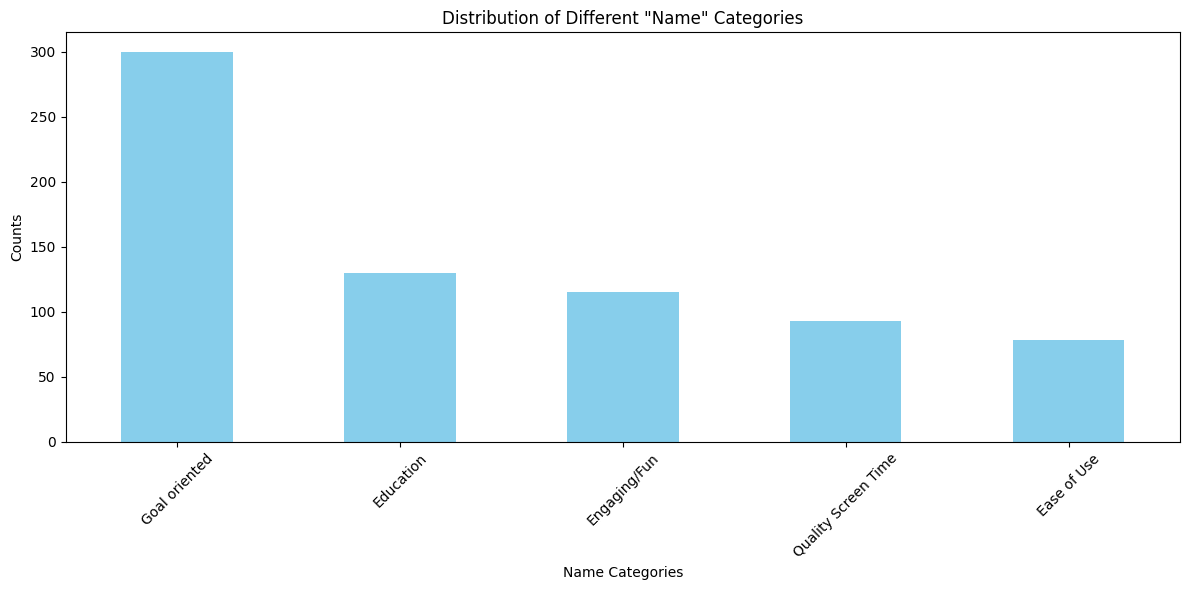

In [10]:
# Calculate the value counts for the 'Name' column
name_counts = df['Name'].value_counts()

# Create a bar chart
plt.figure(figsize=(12, 6))
name_counts[:5].plot(kind='bar', color='skyblue')
plt.title('Distribution of Different "Name" Categories')
plt.xlabel('Name Categories')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as an image file
plt.savefig('name_distribution.png')

# Show the plot
plt.show()

In [11]:
# Get the top 3 most common "Name" values
top_6_codes = name_counts.head(6).index.tolist()

# Print the top 3 names
print(top_6_codes)

['Goal oriented', 'Education', 'Engaging/Fun', 'Quality Screen Time', 'Ease of Use', 'Well Rounded']


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from io import BytesIO
import base64

# Initialize the classifier
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

# Function to analyze emotions in reviews
def analyze_app_emotions(reviews, app_name):
    emotions_df = pd.DataFrame()
    skipped_count = 0
    
    for review in reviews:
        try:
            # Ensure the review is a string
            review = str(review)
            
            # Get emotions for current review
            emotions = classifier(review)
            
            # Create dictionary mapping labels to scores
            row_data = {'review': review, 'Name': app_name}
            for emotion in emotions[0]:
                row_data[emotion['label']] = emotion['score']
                
            # Convert to DataFrame row and concatenate
            review_df = pd.DataFrame([row_data])
            emotions_df = pd.concat([emotions_df, review_df], ignore_index=True)
            
        except RuntimeError as e:
            skipped_count += 1
            continue
    
    return emotions_df

# Function to create combined emotion spider graph
def create_combined_emotion_spider(dfs, labels, title_suffix, colors, figsize=(10, 10)):
    # Combine the dataframes
    combined_df = pd.concat(dfs)
    
    # Calculate means and get top 6 emotions
    emotion_means = combined_df.drop(['review', 'Name'], axis=1).mean()
    top_emotions = dict(sorted(emotion_means.items(), key=lambda x: x[1], reverse=True)[:6])
    
    # Prepare data
    emotions = [emotion.capitalize() for emotion in top_emotions.keys()]
    num_vars = len(emotions)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection='polar'))
    
    # Plot each dataframe
    for i, df in enumerate(dfs):
        emotion_means = df.drop(['review', 'Name'], axis=1).mean()
        values = [emotion_means.get(emotion.lower(), 0) for emotion in emotions]
        values += values[:1]
        
        ax.plot(angles, values, '-o', linewidth=2, color=colors[i], label=labels[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    # Customize chart
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(emotions, size=10)
    ax.set_rgrids([0.1, 0.2, 0.3, 0.4, 0.5])
    
    plt.title(f"Emotional Analysis: {title_suffix}", size=15, y=1.05)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    
    # Save plot to buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image_png = buffer.getvalue()
    graph = base64.b64encode(image_png).decode('utf-8')
    buffer.close()
    plt.show()
    plt.close()
    
    return graph

# Example usage
labels = [
    "toddler-games-for-2-year-olds",
    "khan-academy-kids",
    "kids-math-games",
    "montessori-preschool-kids-3-7",
    "pok-pok-montessori-preschool",
    "toddler-games-for-2-year-olds"
]

# Load dataframes and analyze emotions
dfs = []
for label in labels:
    df = pd.read_excel("../Deductive_Analysis_Mar3.xlsx", sheet_name=f"o-{label}")
    df.rename(columns={'Sentence': 'review', 'Code': 'Name'}, inplace=True)
    

# Load the Excel file
file_path = '../Deductive_Analysis_Mar3.xlsx'
sheets = pd.read_excel(file_path, sheet_name=None)  # Load all sheets into a dictionary

# Combine reviews from sheets with the same app name
combined_reviews = pd.DataFrame()
for sheet_name, df in sheets.items():
    # Normalize the sheet name by removing the 'o-' or 'g-' prefix
    app_name = sheet_name.split('-', 1)[-1]
    df['App Name'] = app_name  # Add a column for the normalized app name
    combined_reviews = pd.concat([combined_reviews, df], ignore_index=True)



In [13]:
labels = combined_reviews['App Name'].unique()

In [14]:
labels

array(['kids-math-games', 'montessori-preschool-kids-3-7',
       'pok-pok-montessori-preschool', 'preschool-games-for-kids',
       'toddler-games-for-2-year-olds', 'abc-kids-tracing-phonics',
       'khan-academy-kids'], dtype=object)

In [15]:
combined_reviews[combined_reviews['App Name'] == labels[0]]

,Sentence,Code,Probability,Justification,Source File,App Name
0,toddler loooves often comes back love activiti...,Auditory Stimuli,0.8,"The sentence mentions ""congratulatory sound"" a...",g-kids-math-games.csv,kids-math-games
1,absolutely fantastic daughter always phone ann...,Open-Ended/Explore,0.8,"The sentence mentions ""daughter always phone a...",g-kids-math-games.csv,kids-math-games
2,absolutely fantastic daughter always phone ann...,Annoying,0.7,"The sentence includes the word ""annoying,"" ind...",g-kids-math-games.csv,kids-math-games
3,idea app great theres one big issue hints enou...,Boring,0.8,The sentence indicates that the user finds the...,g-kids-math-games.csv,kids-math-games
4,great find grand daughter 6 loves app puzzles ...,Goal oriented,0.8,"The sentence mentions activities like puzzles,...",g-kids-math-games.csv,kids-math-games
...,...,...,...,...,...,...
5121,selected thats hints shown app still showing a...,Boring,0.8,The sentence indicates that the user finds the...,o-kids-math-games.csv,kids-math-games
5122,love much,Personalization/Variety,1.0,"The sentence ""love much"" implies a positive se...",o-kids-math-games.csv,kids-math-games
5123,game fun,Engaging/Fun,1.0,"The sentence ""game fun"" clearly indicates that...",o-kids-math-games.csv,kids-math-games
5124,ethan gay roger 13550 ethan 4 years old mommy ...,Age,1.0,The sentence mentions the ages of multiple ind...,o-kids-math-games.csv,kids-math-games


C:\Users\Ryan Jewik\AppData\Local\Temp\ipykernel_16424\1121355069.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Sentence': 'review', 'Code': 'Name'}, inplace=True)
C:\Users\Ryan Jewik\AppData\Local\Temp\ipykernel_16424\1121355069.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Sentence': 'review', 'Code': 'Name'}, inplace=True)
C:\Users\Ryan Jewik\AppData\Local\Temp\ipykernel_16424\1121355069.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

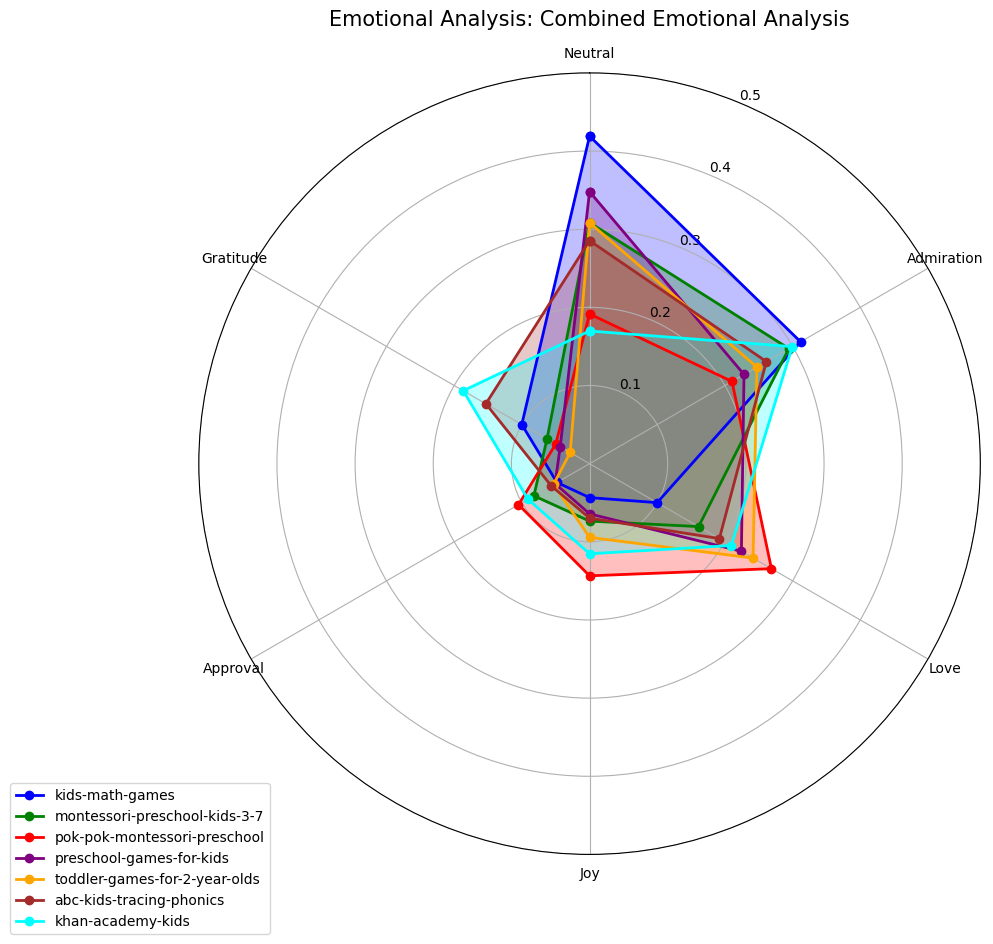

In [16]:
dfs = []
for label in labels:
    df = combined_reviews[combined_reviews['App Name'] == label]
    df.rename(columns={'Sentence': 'review', 'Code': 'Name'}, inplace=True)
    emotion_df = analyze_app_emotions(df['review'], label)
    dfs.append(emotion_df)
    

img = create_combined_emotion_spider(dfs, labels, 'Combined Emotional Analysis', ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'cyan'])

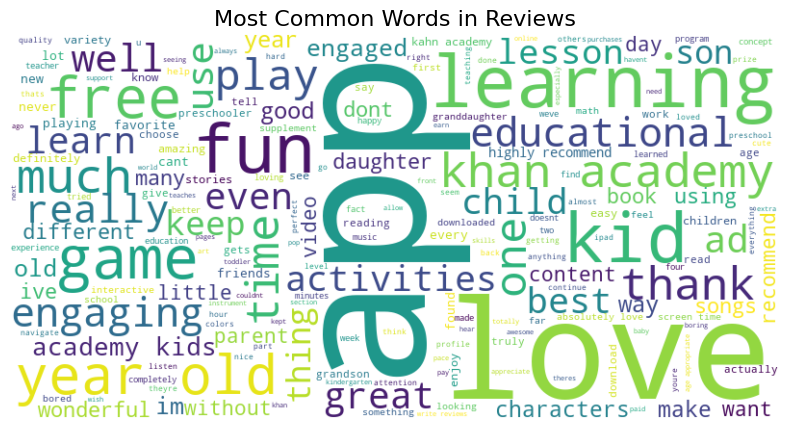

In [28]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Combine all reviews into a single string
text = " ".join(review for review in dfs[6]['review'].dropna())

# Define stopwords to exclude common words
stopwords = set(STOPWORDS)

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stopwords,
    colormap='viridis',
    max_words=200
).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Most Common Words in Reviews', fontsize=16)
plt.show()

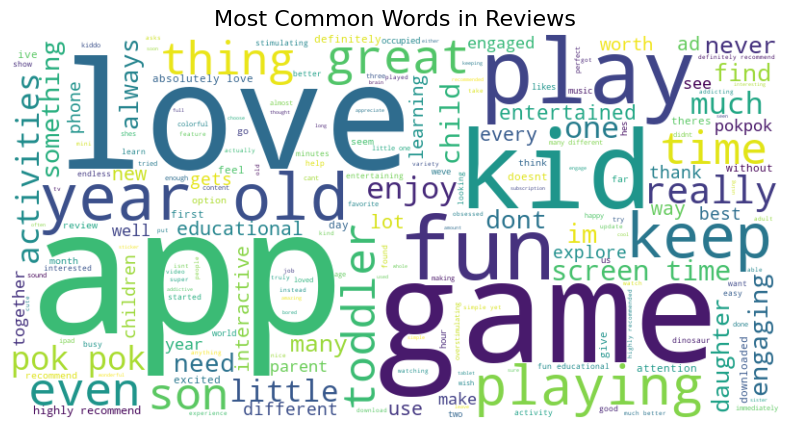

In [29]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Combine all reviews into a single string
text = " ".join(review for review in dfs[2]['review'].dropna())

# Define stopwords to exclude common words
stopwords = set(STOPWORDS)

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stopwords,
    colormap='viridis',
    max_words=200
).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Most Common Words in Reviews', fontsize=16)
plt.show()

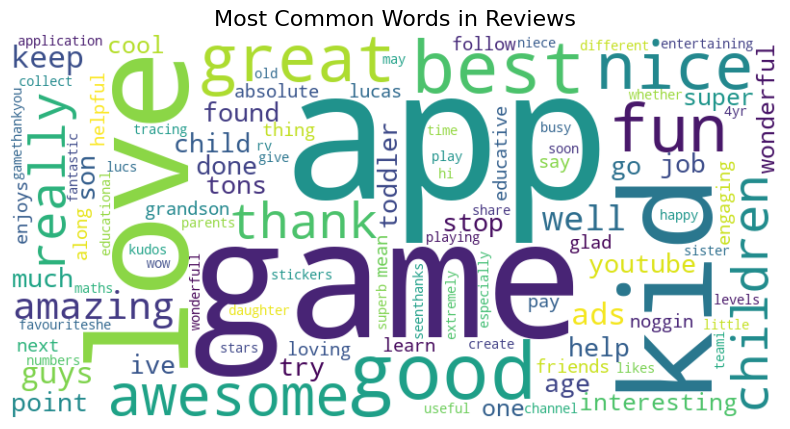

In [30]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Combine all reviews into a single string
text = " ".join(review for review in dfs[0]['review'].dropna())

# Define stopwords to exclude common words
stopwords = set(STOPWORDS)

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stopwords,
    colormap='viridis',
    max_words=200
).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Most Common Words in Reviews', fontsize=16)
plt.show()

In [17]:
labels

array(['kids-math-games', 'montessori-preschool-kids-3-7',
       'pok-pok-montessori-preschool', 'preschool-games-for-kids',
       'toddler-games-for-2-year-olds', 'abc-kids-tracing-phonics',
       'khan-academy-kids'], dtype=object)

C:\Users\Ryan Jewik\AppData\Local\Temp\ipykernel_16424\2692190574.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Sentence': 'review', 'Code': 'Name'}, inplace=True)
C:\Users\Ryan Jewik\AppData\Local\Temp\ipykernel_16424\2692190574.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Sentence': 'review', 'Code': 'Name'}, inplace=True)
C:\Users\Ryan Jewik\AppData\Local\Temp\ipykernel_16424\2692190574.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

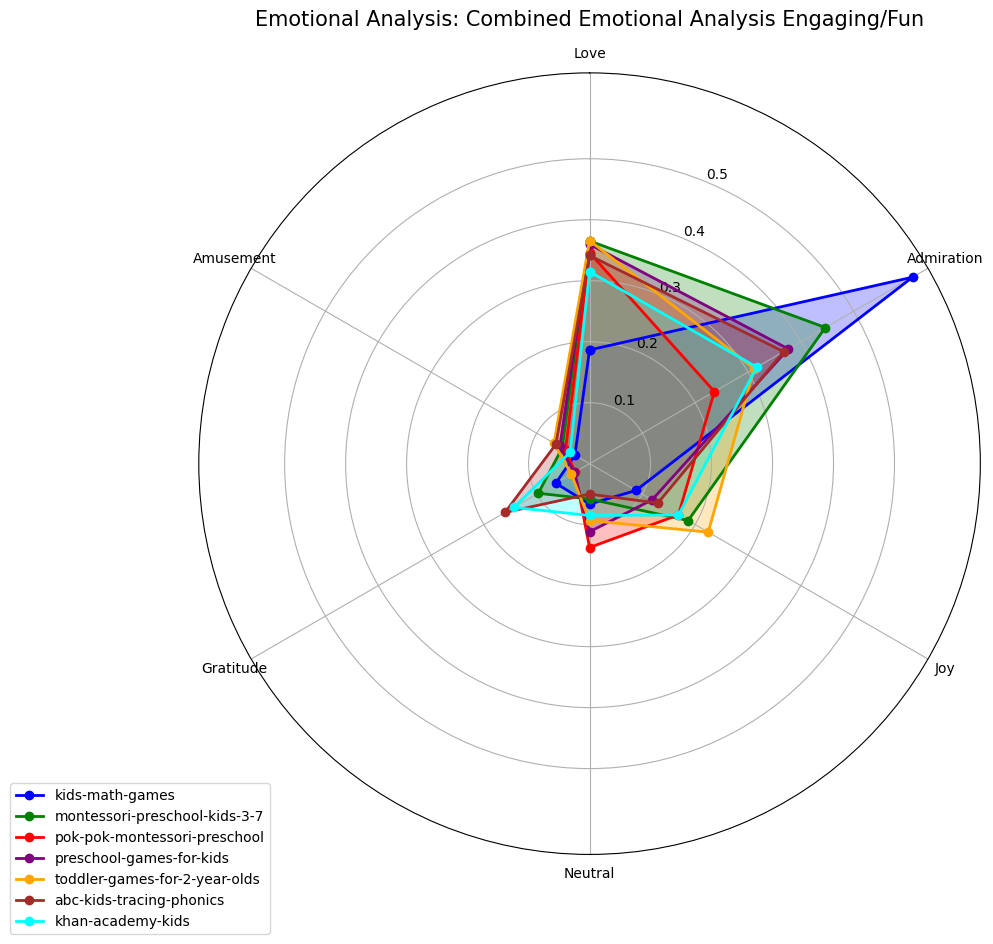

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from io import BytesIO
import base64

# Initialize the classifier
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

# Function to analyze emotions in reviews
def analyze_app_emotions(reviews, app_name):
    emotions_df = pd.DataFrame()
    skipped_count = 0
    
    for review in reviews:
        try:
            # Ensure the review is a string
            review = str(review)
            
            # Get emotions for current review
            emotions = classifier(review)
            
            # Create dictionary mapping labels to scores
            row_data = {'review': review, 'Name': app_name}
            for emotion in emotions[0]:
                row_data[emotion['label']] = emotion['score']
                
            # Convert to DataFrame row and concatenate
            review_df = pd.DataFrame([row_data])
            emotions_df = pd.concat([emotions_df, review_df], ignore_index=True)
            
        except RuntimeError as e:
            skipped_count += 1
            continue
    
    return emotions_df

# Function to create combined emotion spider graph
def create_combined_emotion_spider(dfs, labels, title_suffix, colors, figsize=(10, 10)):
    # Combine the dataframes
    combined_df = pd.concat(dfs)
    
    # Calculate means and get top 6 emotions
    emotion_means = combined_df.drop(['review', 'Name'], axis=1).mean()
    top_emotions = dict(sorted(emotion_means.items(), key=lambda x: x[1], reverse=True)[:6])
    
    # Prepare data
    emotions = [emotion.capitalize() for emotion in top_emotions.keys()]
    num_vars = len(emotions)
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection='polar'))
    
    # Plot each dataframe
    for i, df in enumerate(dfs):
        emotion_means = df.drop(['review', 'Name'], axis=1).mean()
        values = [emotion_means.get(emotion.lower(), 0) for emotion in emotions]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, color=colors[i], label=labels[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    # Customize chart
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(emotions, size=10)
    ax.set_rgrids([0.1, 0.2, 0.3, 0.4, 0.5])
    
    plt.title(f"Emotional Analysis: {title_suffix}", size=15, y=1.05)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    
    # Save plot to buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image_png = buffer.getvalue()
    graph = base64.b64encode(image_png).decode('utf-8')
    buffer.close()
    plt.show()
    plt.close()
    
    return graph

    
dfs = []
code_counts = combined_reviews['Code'].value_counts()
# Get the top 3 most common "Name" values
top_6_codes = code_counts.head(6).index.tolist()

for label in labels:
    df = combined_reviews[combined_reviews['App Name'] == label]
    df.rename(columns={'Sentence': 'review', 'Code': 'Name'}, inplace=True)
    emotion_df = analyze_app_emotions(df[df['Name'] == top_6_codes[0]]['review'], label)
    dfs.append(emotion_df)




# Create combined spider graph
img = create_combined_emotion_spider(dfs, labels, f'Combined Emotional Analysis {top_6_codes[0]}', ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'cyan'])

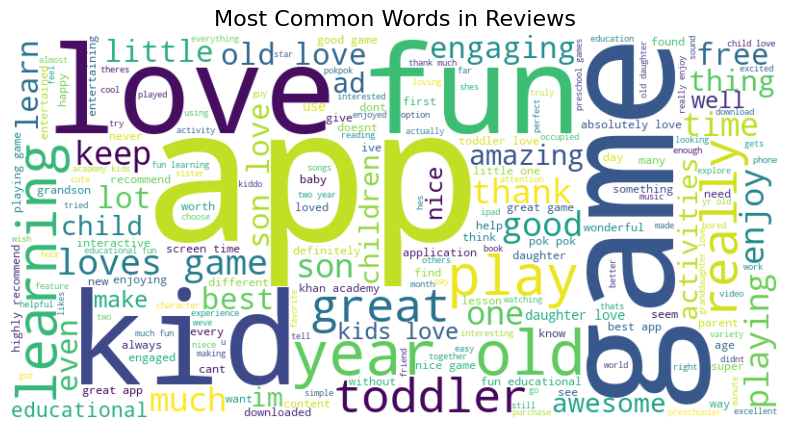

In [27]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Combine all reviews from all DataFrames in the list into a single string
text = " ".join(review for df in dfs for review in df['review'].dropna())

# Define stopwords to exclude common words
stopwords = set(STOPWORDS)

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stopwords,
    colormap='viridis',
    max_words=200
).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Most Common Words in Reviews', fontsize=16)
plt.show()

In [19]:
code_counts

Code
Engaging/Fun               1110
Goal oriented               878
Education                   612
Ease of Use                 600
Personalization/Variety     407
                           ... 
Controls                      1
Effective                     1
Appreciation                  1
Glitches                      1
Confusing                     1
Name: count, Length: 119, dtype: int64

C:\Users\Ryan Jewik\AppData\Local\Temp\ipykernel_16424\1435163260.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Sentence': 'review', 'Code': 'Name'}, inplace=True)
C:\Users\Ryan Jewik\AppData\Local\Temp\ipykernel_16424\1435163260.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Sentence': 'review', 'Code': 'Name'}, inplace=True)
C:\Users\Ryan Jewik\AppData\Local\Temp\ipykernel_16424\1435163260.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

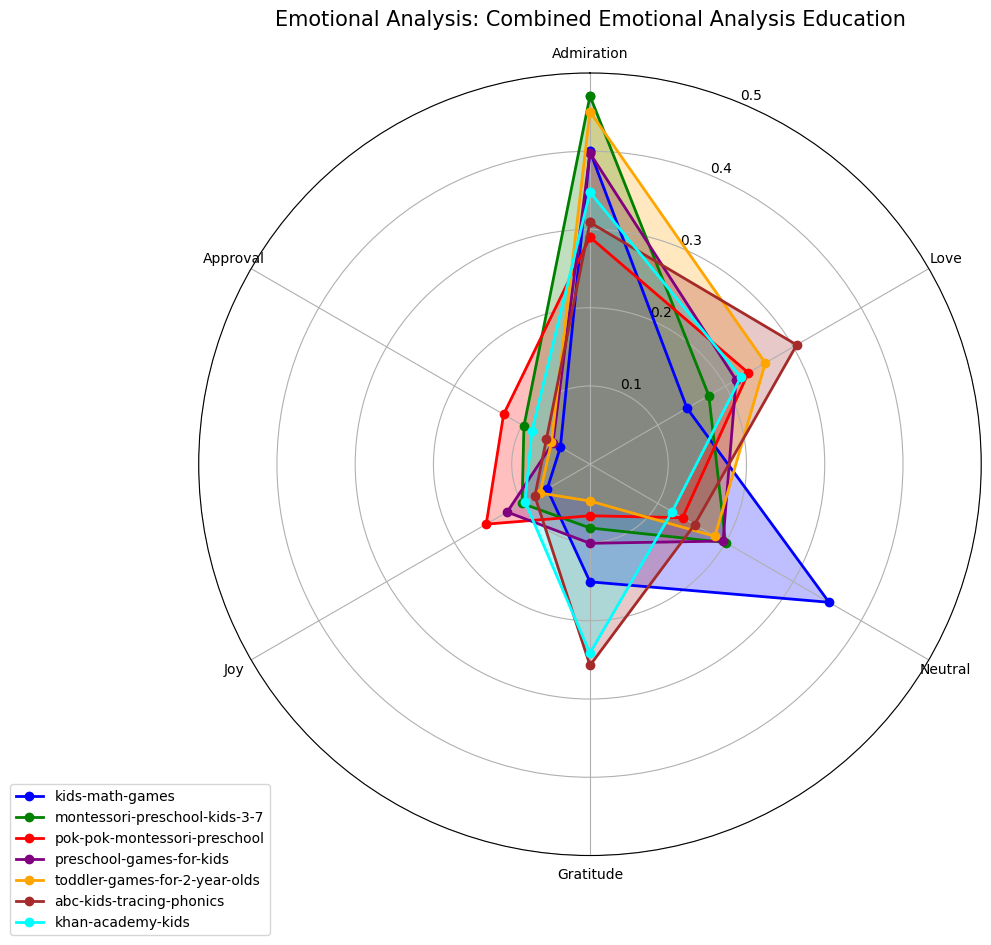

In [20]:

dfs = []
code_counts = combined_reviews['Code'].value_counts()
# Get the top 3 most common "Name" values
top_6_codes = code_counts.head(6).index.tolist()

for label in labels:
    df = combined_reviews[combined_reviews['App Name'] == label]
    df.rename(columns={'Sentence': 'review', 'Code': 'Name'}, inplace=True)
    emotion_df = analyze_app_emotions(df[df['Name'] == top_6_codes[2]]['review'], label)
    dfs.append(emotion_df)




# Create combined spider graph
img = create_combined_emotion_spider(dfs, labels, f'Combined Emotional Analysis {top_6_codes[2]}', ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'cyan'])

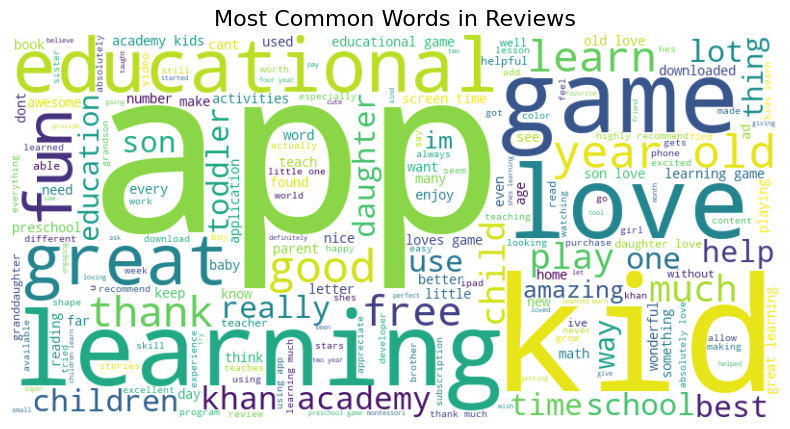

In [ ]:
# Combine all reviews from all DataFrames in the list into a single string
text = " ".join(review for df in dfs for review in df['review'].dropna())

# Define stopwords to exclude common words
stopwords = set(STOPWORDS)

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stopwords,
    colormap='viridis',
    max_words=200
).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Most Common Words in Reviews', fontsize=16)
plt.show()

C:\Users\Ryan Jewik\AppData\Local\Temp\ipykernel_16424\4198353702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Sentence': 'review', 'Code': 'Name'}, inplace=True)
C:\Users\Ryan Jewik\AppData\Local\Temp\ipykernel_16424\4198353702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Sentence': 'review', 'Code': 'Name'}, inplace=True)
C:\Users\Ryan Jewik\AppData\Local\Temp\ipykernel_16424\4198353702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

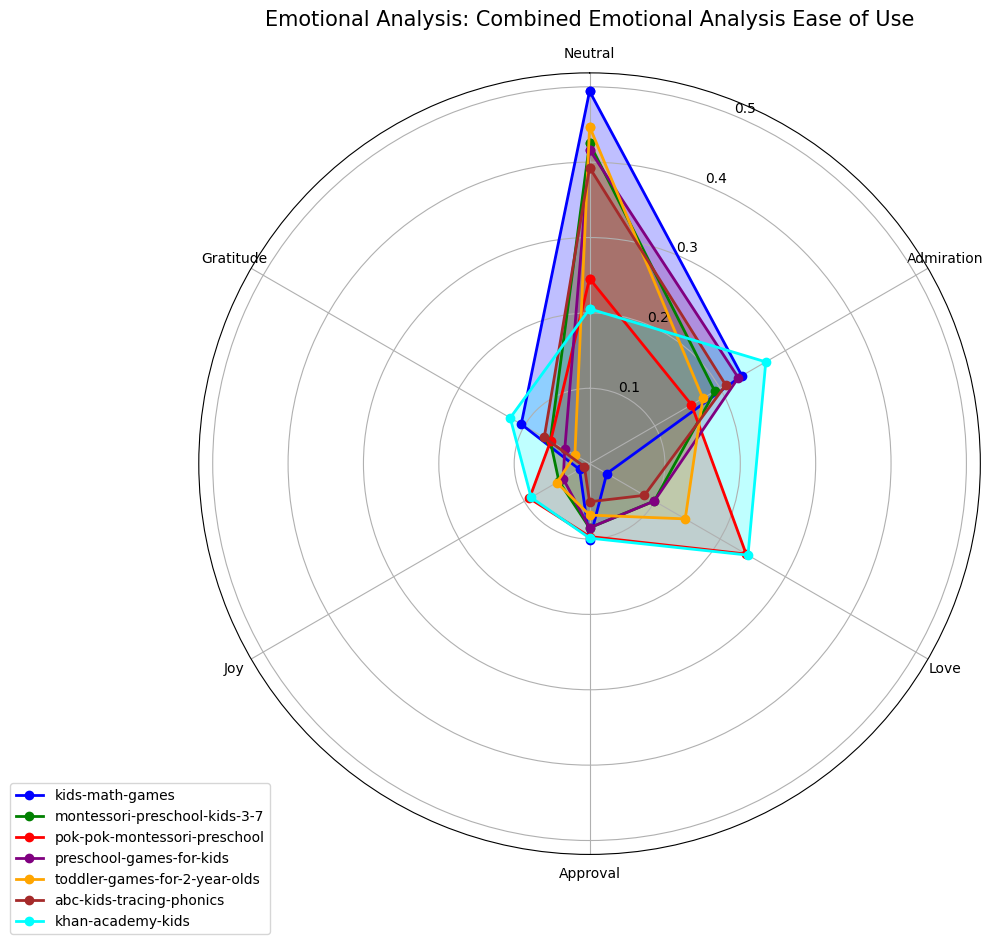

In [34]:

dfs = []
code_counts = combined_reviews['Code'].value_counts()
# Get the top 3 most common "Name" values
top_6_codes = code_counts.head(6).index.tolist()

for label in labels:
    df = combined_reviews[combined_reviews['App Name'] == label]
    df.rename(columns={'Sentence': 'review', 'Code': 'Name'}, inplace=True)
    emotion_df = analyze_app_emotions(df[df['Name'] == top_6_codes[3]]['review'], label)
    dfs.append(emotion_df)




# Create combined spider graph
img = create_combined_emotion_spider(dfs, labels, f'Combined Emotional Analysis {top_6_codes[3]}', ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'cyan'])

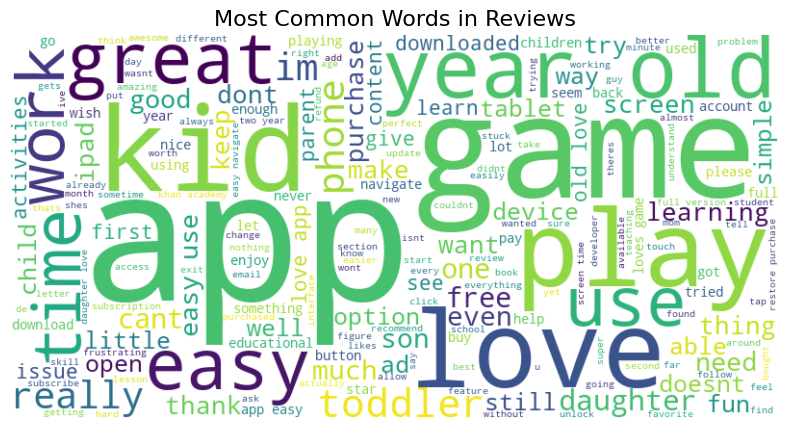

In [35]:
# Combine all reviews from all DataFrames in the list into a single string
text = " ".join(review for df in dfs for review in df['review'].dropna())

# Define stopwords to exclude common words
stopwords = set(STOPWORDS)

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stopwords,
    colormap='viridis',
    max_words=200
).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Most Common Words in Reviews', fontsize=16)
plt.show()

C:\Users\Ryan Jewik\AppData\Local\Temp\ipykernel_16424\663488094.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Sentence': 'review', 'Code': 'Name'}, inplace=True)
C:\Users\Ryan Jewik\AppData\Local\Temp\ipykernel_16424\663488094.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Sentence': 'review', 'Code': 'Name'}, inplace=True)
C:\Users\Ryan Jewik\AppData\Local\Temp\ipykernel_16424\663488094.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

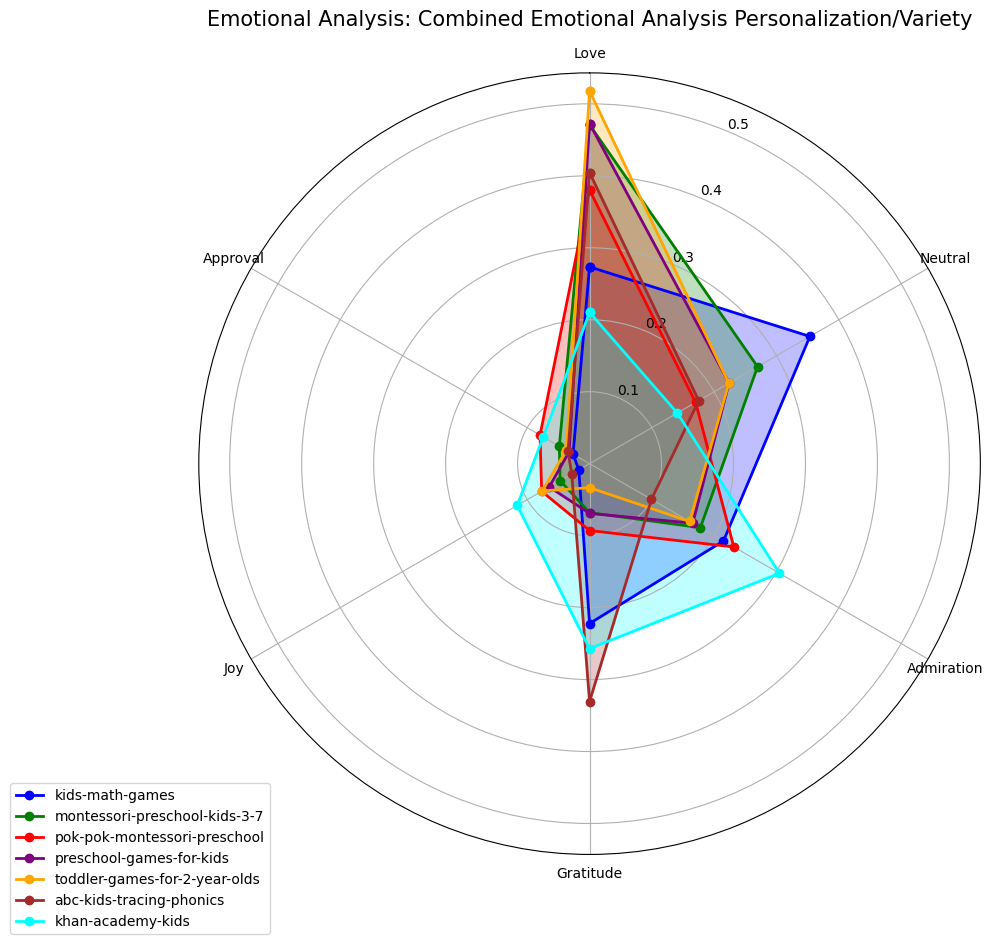

In [32]:

dfs = []
code_counts = combined_reviews['Code'].value_counts()
# Get the top 3 most common "Name" values
top_6_codes = code_counts.head(6).index.tolist()

for label in labels:
    df = combined_reviews[combined_reviews['App Name'] == label]
    df.rename(columns={'Sentence': 'review', 'Code': 'Name'}, inplace=True)
    emotion_df = analyze_app_emotions(df[df['Name'] == top_6_codes[4]]['review'], label)
    dfs.append(emotion_df)




# Create combined spider graph
img = create_combined_emotion_spider(dfs, labels, f'Combined Emotional Analysis {top_6_codes[4]}', ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'cyan'])

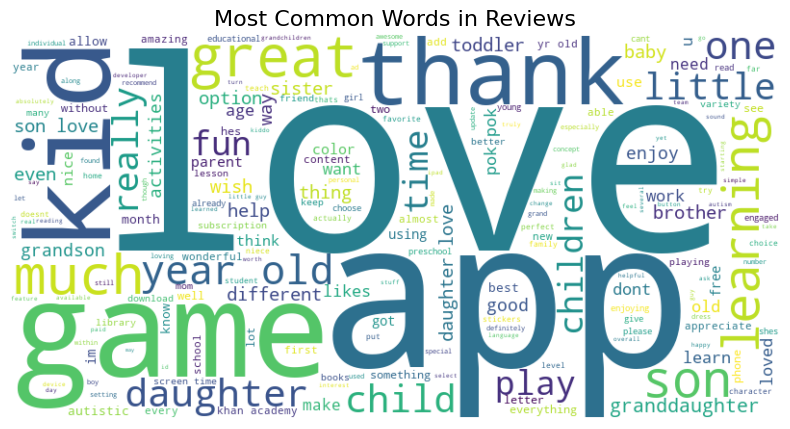

In [33]:
# Combine all reviews from all DataFrames in the list into a single string
text = " ".join(review for df in dfs for review in df['review'].dropna())

# Define stopwords to exclude common words
stopwords = set(STOPWORDS)

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stopwords,
    colormap='viridis',
    max_words=200
).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Most Common Words in Reviews', fontsize=16)
plt.show()

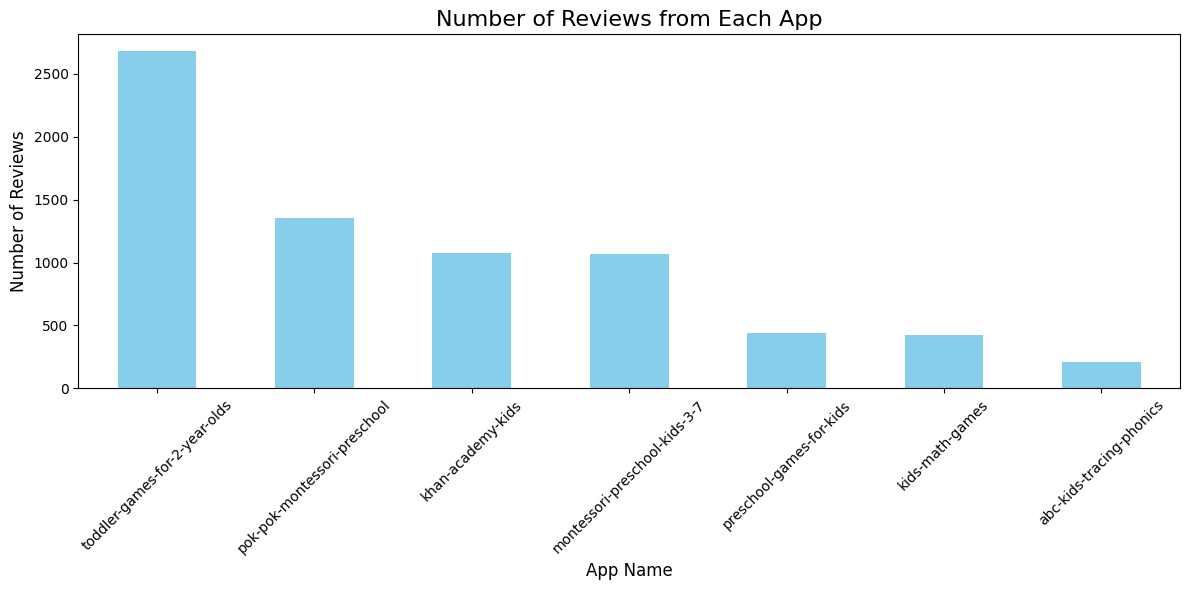

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = '../Deductive_Analysis_Mar3.xlsx'
sheets = pd.read_excel(file_path, sheet_name=None)  # Load all sheets into a dictionary

# Combine reviews from sheets with the same app name
combined_reviews = pd.DataFrame()
for sheet_name, df in sheets.items():
    # Normalize the sheet name by removing the 'o-' or 'g-' prefix
    app_name = sheet_name.split('-', 1)[-1]
    df['App Name'] = app_name  # Add a column for the normalized app name
    combined_reviews = pd.concat([combined_reviews, df], ignore_index=True)

# Count the number of reviews for each app
review_counts = combined_reviews['App Name'].value_counts()

# Create a bar chart
plt.figure(figsize=(12, 6))
review_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Reviews from Each App', fontsize=16)
plt.xlabel('App Name', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()